# Load ads

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'. Needed to remove SettingWithCopyWarning warning when assigning new value to dataframe column
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px

import statsmodels.formula.api as smf
import statsmodels.api as sm

%load_ext autoreload
%autoreload 2

# from housing_crawler.utils import save_file, get_file, get_grid_polygons_all_cities
from housing_crawler.analysis.ads_table_processing import get_processed_ads_table
from housing_crawler.string_utils import remove_prefix, simplify_address, standardize_characters, capitalize_city_name, german_characters
from housing_crawler.utils import standardize_features, return_significative_coef


from config.config import ROOT_DIR
from housing_crawler.params import dict_city_number_wggesucht

In [2]:
ads_feat_df = get_processed_ads_table()
list(ads_feat_df.columns)

===> Loaded all_encoded.csv locally
===> ads_OSM.csv saved locally


['id',
 'url',
 'commercial_landlord',
 'title',
 'price_euros',
 'size_sqm',
 'available_rooms',
 'capacity',
 'available_spots_wg',
 'male_flatmates',
 'female_flatmates',
 'diverse_flatmates',
 'published_on',
 'published_at',
 'address',
 'city',
 'crawler',
 'latitude',
 'longitude',
 'available_from',
 'available_to',
 'details_searched',
 'cold_rent_euros',
 'mandatory_costs_euros',
 'extra_costs_euros',
 'schufa_needed',
 'deposit',
 'zip_code',
 'home_total_size',
 'smoking',
 'energy',
 'wg_possible',
 'building_type',
 'building_floor',
 'furniture',
 'kitchen',
 'shower_type',
 'floor_type',
 'heating',
 'public_transport_distance',
 'internet',
 'parking',
 'transfer_costs_euros',
 'type_offer_simple',
 'min_age_flatmates',
 'max_age_flatmates',
 'gender_searched',
 'min_age_searched',
 'max_age_searched',
 'number_languages',
 'extras_waschmaschine',
 'extras_spuelmaschine',
 'extras_terrasse',
 'extras_balkon',
 'extras_garten',
 'extras_gartenmitbenutzung',
 'extras_kel

In [3]:
# Number of duplicate data points
# It's very likely zero cause I already removed dulicated IDs during processing
ads_feat_df.duplicated().sum()

0

In [4]:
# Percentage missing values per column
(ads_feat_df.isnull().sum().sort_values(ascending=False)/len(ads_feat_df)*100)[0:30]

energy                       94.598298
shower_type                  88.849791
heating                      88.426858
home_total_size              88.232309
max_age_flatmates            87.636819
min_age_flatmates            86.618396
internet                     86.329110
parking                      85.002791
floor_type                   83.155419
building_type                80.257482
public_transport_distance    79.418382
building_floor               77.909357
zip_code                     75.449578
extras_keller                75.407285
extras_gartenmitbenutzung    75.407285
extras_garten                75.407285
extras_spuelmaschine         75.407285
extras_balkon                75.407285
extras_terrasse              75.407285
min_age_searched             75.407285
extras_waschmaschine         75.407285
max_age_searched             75.407285
extras_aufzug                75.407285
languages_englisch           75.407285
extras_fahrradkeller         75.407285
extras_dachboden         

# Creating WG, single-room and multi-room dataframes

In [5]:
wg_df = ads_feat_df.query('type_offer_simple == "WG"').reset_index().drop(columns=['index'])

singleroom_df = ads_feat_df.query('type_offer_simple == "Single-room flat"').reset_index().drop(columns=['index'])

flathouse_df = ads_feat_df.query('(type_offer_simple == "Apartment")').reset_index().drop(columns=['index'])

# Linear model WG

In [6]:
wg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43580 entries, 0 to 43579
Columns: 125 entries, id to cos_day_week_int
dtypes: Float64(2), Int64(1), datetime64[ns](3), float64(96), int64(6), object(17)
memory usage: 41.7+ MB


In [39]:
# define columns to work
features = [
    'km_to_centroid',
    'sin_degrees_to_centroid',
    'cos_degrees_to_centroid',
    
    'comfort_leisure_spots',
    'comfort_warehouse',
    'activities_education',
    'mobility_public_transport_bus',
    'activities_economic',
    'comfort_industrial',
    'activities_goverment',
    'social_life_eating',
    'comfort_comfort_spots',
    'social_life_culture',
    'activities_supermarket',
##     'activities_public_service',
    'social_life_community',
    'comfort_leisure_mass',
    'activities_educational',
    'mobility_street_secondary',
    'mobility_public_transport_rail',
    'activities_retail',
    'social_life_night_life',
    'comfort_green_natural',
    'comfort_railway',
    'mobility_bike_infraestructure',
##     'comfort_green_forests',
    'mobility_street_primary',
    'comfort_lakes',
##     'activities_health_regional',
    'activities_health_local',
    'comfort_green_space',
    'comfort_rivers',
    'activities_post',
    'comfort_green_parks',
    'comfort_street_motorway'
]

target = 'price_euros'#'price_per_sqm'

selected_num_features = [
            'size_sqm',
#             'days_available',
            'capacity',
#             'male_flatmates',
#             'female_flatmates',
#             'diverse_flatmates',
    
#             'cold_rent_euros',
#             'mandatory_costs_euros',
#             'extra_costs_euros',
            'transfer_costs_euros',
#             'deposit',
    
            'furniture',
            'kitchen',
#             'public_transport_distance',
#             'home_total_size',
            'smoking',
#             'building_floor',
    
#             'min_age_flatmates',
#             'max_age_flatmates',
    
            'min_age_searched',
            'max_age_searched',
    
            'number_languages',
    
#             'sin_published_at',
#             'cos_published_at',
#             'sin_day_week_int',
#             'cos_day_week_int'
    
] + features
selected_cat_features = ['city',
                         'commercial_landlord',
            'rental_length_term',
#             'energy',
#             'wg_possible',
            'building_type',
#             'shower_type',
#             'floor_type',
#             'heating',
#             'internet',
#             'parking',
                         
            'schufa_needed',
                         
            'extras_waschmaschine',
            'extras_spuelmaschine',
            'extras_terrasse',
            'extras_balkon',
            'extras_garten',
#             'extras_gartenmitbenutzung',
            'extras_keller',
            'extras_aufzug',
            'extras_haustiere',
            'extras_fahrradkeller',
            'extras_dachboden',
                         
#             'languages_deutsch',
#             'languages_englisch',
                         
            'wg_type_studenten',
            'wg_type_keine_zweck',
            'wg_type_maenner',
            'wg_type_business',
            'wg_type_wohnheim',
            'wg_type_vegetarisch_vegan',
            'wg_type_alleinerziehende',
            'wg_type_funktionale',
            'wg_type_berufstaetigen',
            'wg_type_gemischte',
            'wg_type_mit_kindern',
            'wg_type_verbindung',
            'wg_type_lgbtqia',
            'wg_type_senioren',
            'wg_type_inklusive',
            'wg_type_wg_neugruendung',
                         
#             'tv_kabel',
#             'tv_satellit',
                         
            'gender_searched',
                         
#             'age_category_searched'
                        ]
all_columns = [target] + selected_num_features + selected_cat_features

columns_to_zscore = selected_num_features


# Filter dataframe for modelling
df_zscored = wg_df[all_columns#+['city']
                     ].copy()

df_zscored.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43580 entries, 0 to 43579
Data columns (total 74 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   price_euros                     43580 non-null  float64
 1   size_sqm                        43580 non-null  float64
 2   capacity                        43580 non-null  float64
 3   transfer_costs_euros            10357 non-null  float64
 4   furniture                       10357 non-null  float64
 5   kitchen                         10357 non-null  float64
 6   smoking                         10357 non-null  float64
 7   min_age_searched                10357 non-null  float64
 8   max_age_searched                10357 non-null  float64
 9   number_languages                10357 non-null  float64
 10  km_to_centroid                  20986 non-null  float64
 11  sin_degrees_to_centroid         20986 non-null  float64
 12  cos_degrees_to_centroid         

In [40]:
df_zscored = df_zscored.dropna(axis=0)
# z-scoring columns
df_zscored = standardize_features(df_zscored, columns_to_zscore)

# Filter table if needed
df_city = df_zscored#[df_zscored['city'] == 'Leipzig']
df_city.shape

(4077, 74)

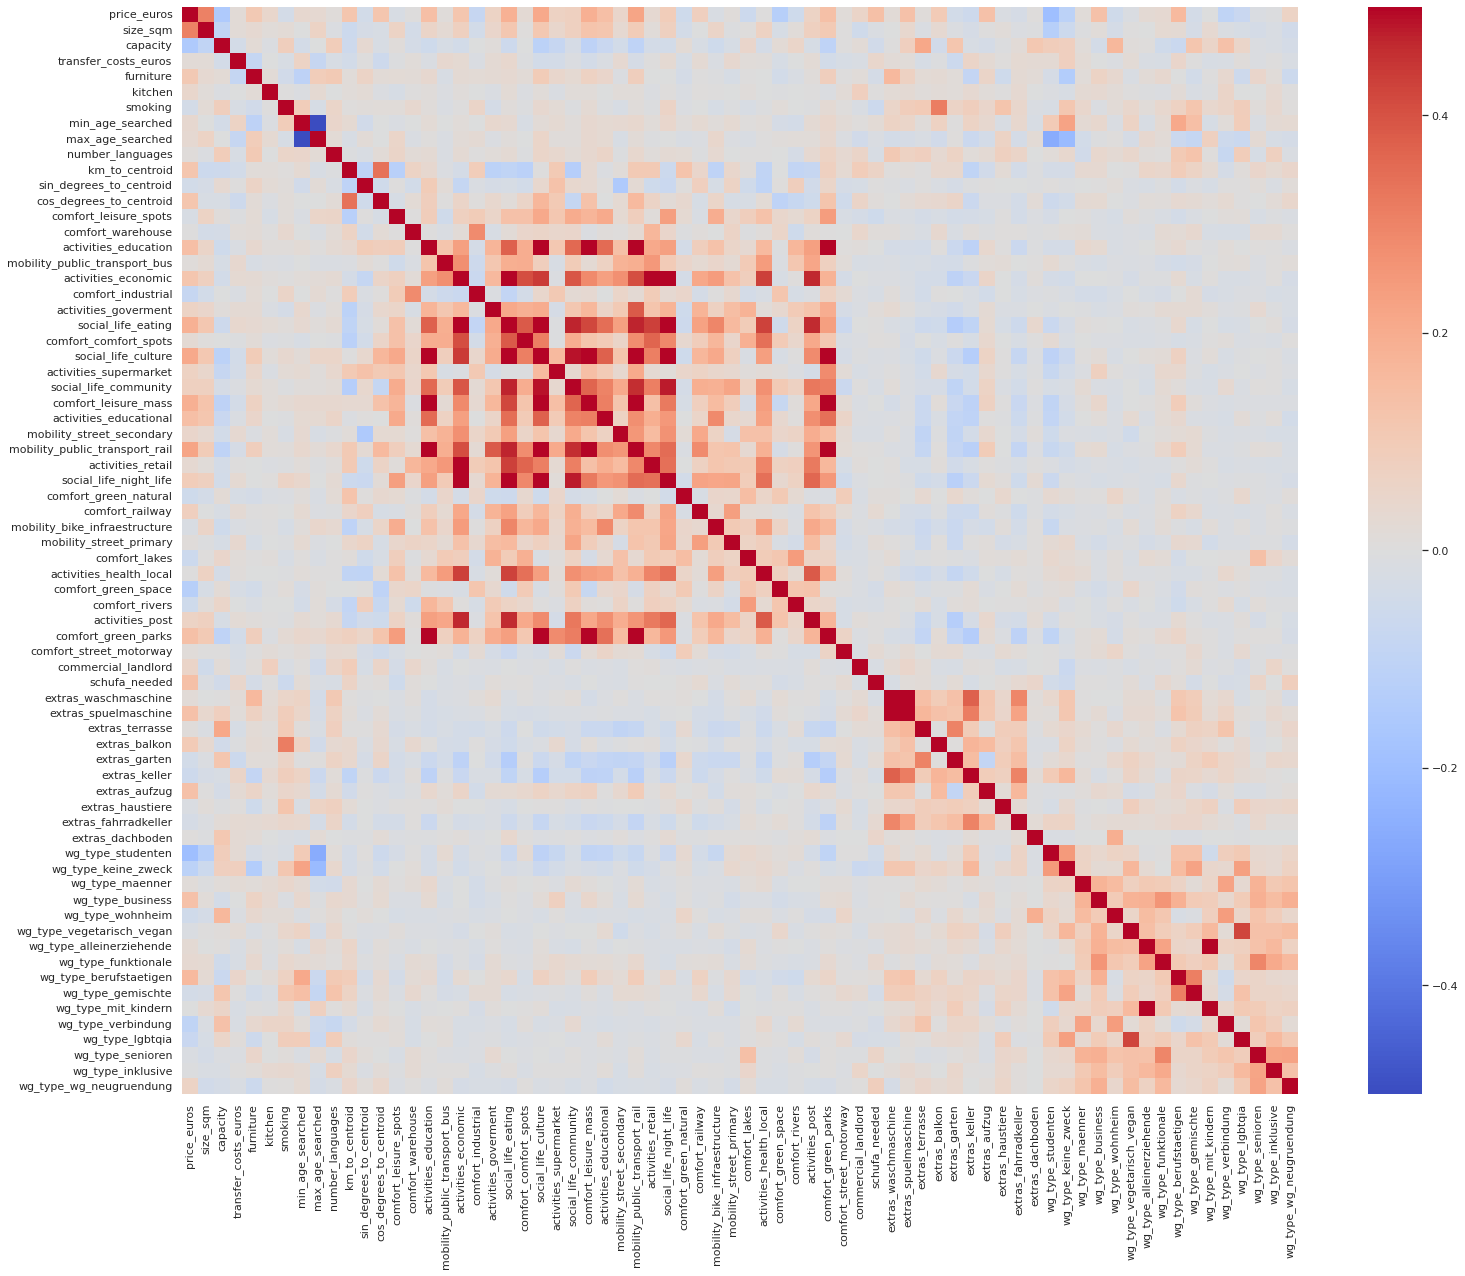

In [41]:
sns.set_theme(style = "whitegrid", font_scale= 1)
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(25, 20))

data_corr = df_city.corr()
sns.heatmap(data_corr, cmap='coolwarm', 
            annot = False, 
            annot_kws={"size": 8},
            vmin=-0.5, vmax=0.5);

In [42]:
data_corr = df_city.corr()

corr_df = data_corr.unstack().reset_index() # Unstack correlation matrix 
corr_df.columns = ['feature_1','feature_2', 'correlation'] # rename columns
corr_df.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] # Remove self correlation
corr_df.head(30)

,feature_1,feature_2,correlation
1568,social_life_culture,mobility_public_transport_rail,0.744559
1982,mobility_public_transport_rail,social_life_culture,0.744559
1210,activities_economic,social_life_eating,0.719254
1417,social_life_eating,activities_economic,0.719254
1772,comfort_leisure_mass,social_life_culture,0.693514
1565,social_life_culture,comfort_leisure_mass,0.693514
1430,social_life_eating,social_life_night_life,0.670593
2120,social_life_night_life,social_life_eating,0.670593
1985,mobility_public_transport_rail,comfort_leisure_mass,0.665723
1778,comfort_leisure_mass,mobility_public_transport_rail,0.665723


In [43]:
# Variation Inflation Factor (VIF) analysis
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
df = pd.DataFrame()

df["features"] = columns_to_zscore

df["vif_index"] = [vif(df_city[columns_to_zscore].values, i) for i in range(df_city[columns_to_zscore].shape[1])]

round(df.sort_values(by="vif_index", ascending = False),2)

,features,vif_index
27,mobility_public_transport_rail,4.33
21,social_life_culture,3.85
19,social_life_eating,3.40
16,activities_economic,2.74
24,comfort_leisure_mass,2.73
6,min_age_searched,2.64
7,max_age_searched,2.61
29,social_life_night_life,2.42
39,comfort_green_parks,2.36
14,activities_education,2.07


In [44]:
# OLS model
formula = target + ' ~ ' + ' + '.join(selected_num_features) + ' + ' + ' + '.join(['C('+feat+')-1' for feat in selected_cat_features]) + '-1'

model_city = smf.ols(formula = formula, data=df_city).fit()
model_city.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            price_euros   R-squared:                       0.524
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     40.45
Date:                Fri, 26 Aug 2022   Prob (F-statistic):               0.00
Time:                        12:02:22   Log-Likelihood:                -25296.
No. Observations:                4077   AIC:                         5.081e+04
Df Residuals:                    3968   BIC:                         5.150e+04
Df Model:                         108                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
C(city)[Aachen]                        357.4154     33.829     10.565      0.000     291.092     423.739
C(city)[Berlin]                        488.2925     31.553     15.475      0.000     426.431     550.154
C(city)[Bonn]                          399.0322     34.406     11.598      0.000     331.577     466.488
C(city)[Bremen]                        378.5716     33.368     11.345      0.000     313.151     443.993
C(city)[Darmstadt]                     411.7429     34.533     11.923      0.000     344.039     479.447
C(city)[Dresden]                       283.5728     33.140      8.557      0.000     218.600     348.546
C(city)[Frankfurt am Main]             480.3780     32.584     14.743      0.000     416.495     544.261
C(city)[Göttingen]                     339.8962     35.029      9.703      0.000     271.220     408.573
C(city)[Hamburg]                       596.8167     37.824     15.779      0.000     522.661     670.973
C(city)[Hannover]                      360.4845     33.302     10.825      0.000     295.194     425.775
C(city)[Heidelberg]                    414.9832     34.239     12.120      0.000     347.856     482.111
C(city)[Karlsruhe]                     374.1932     32.945     11.358      0.000     309.603     438.783
C(city)[Kiel]                          319.9827     35.397      9.040      0.000     250.584     389.382
C(city)[Köln]                          449.2975     32.341     13.893      0.000     385.891     512.704
C(city)[Leipzig]                       277.8950     31.928      8.704      0.000     215.299     340.491
C(city)[Mainz]                         406.2021     34.214     11.872      0.000     339.124     473.280
C(city)[Mannheim]                      369.5301     35.277     10.475      0.000     300.367     438.694
C(city)[München]                       637.5224     31.822     20.034      0.000     575.133     699.911
C(city)[Münster]                       355.5382     33.958     10.470      0.000     288.962     422.115
C(city)[Nürnberg]                      369.4890     35.297     10.468      0.000     300.286     438.692
C(city)[Regensburg]                    379.9612     35.757     10.626      0.000     309.858     450.065
C(city)[Stuttgart]                     471.9721     31.991     14.753      0.000     409.251     534.693
C(city)[Tübingen]                      407.9797     37.792     10.795      0.000     333.886     482.074
C(city)[Würzburg]                      361.2252     34.595     10.442      0.000     293.400     429.050
C(commercial_landlord)[T.1]             85.7836     23.182      3.700      0.000      40.333     131.234
C(rental_length_term)[T.<270days]        2.2019      9.576      0.230      0.818     -16.573      20.977
C(rental_length_term)[T.<365days]     

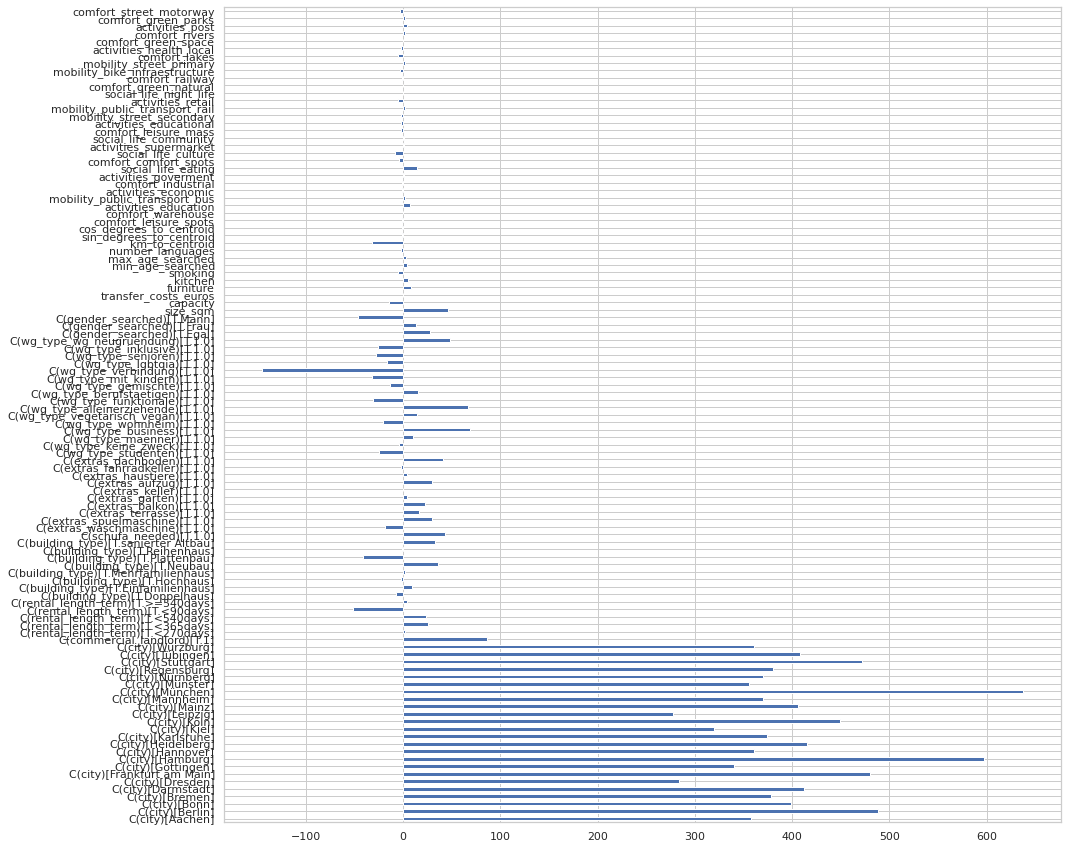

In [45]:
sns.set_theme(style = "whitegrid", font_scale= 1)
fig = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))

model_city.params[0:].plot(kind='barh');

RMSE: 119.7891035258236
RMSE base model: 173.63504945813327


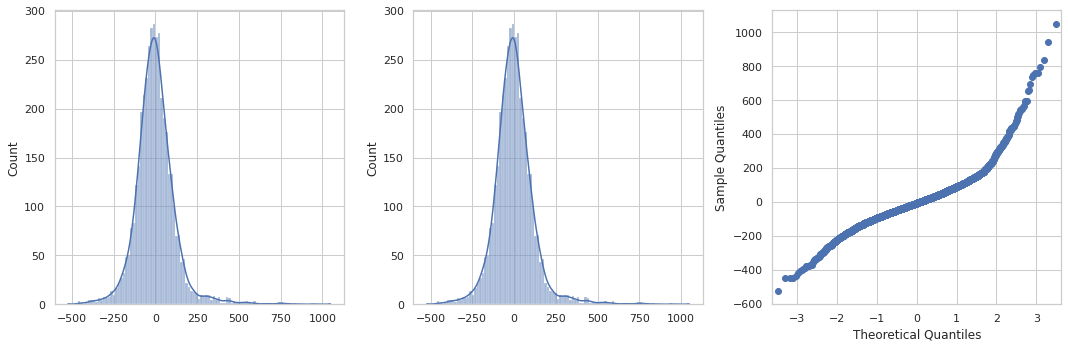

In [46]:
y_pred = model_city.predict(df_city)
y_base = [np.mean(df_city['price_euros'])]*len(y_pred)
y_true = df_city['price_euros']

print(f'RMSE: {np.sqrt(((y_pred - y_true) ** 2).mean())}')
print(f'RMSE base model: {np.sqrt(((y_base - y_true) ** 2).mean())}')

n=len(df_city)
residuals = y_pred - y_true
residuals_base = y_pred - y_true
# residuals.std()/orders.delay_vs_expected.std() * 1/(n**0.5)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
sns.histplot(-residuals, kde=True, edgecolor='w', ax=ax1)
sns.histplot(-residuals_base, kde=True, edgecolor='w', ax=ax2)

# https://stats.stackexchange.com/questions/101274/how-to-interpret-a-qq-plot
sm.qqplot(model_city.resid, ax=ax3)
plt.tight_layout()
fig.show();

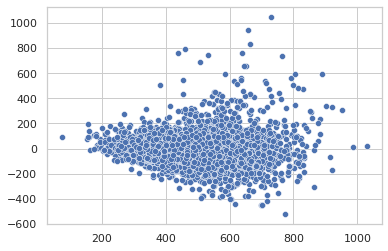

In [47]:
sns.scatterplot(x=model_city.predict(df_city), y=model_city.resid);

                                            p_value        coef
variable                                                       
C(city)[München]                       3.953907e-85  637.522412
C(city)[Hamburg]                       1.904860e-54  596.816726
C(city)[Berlin]                        1.689093e-52  488.292545
C(city)[Frankfurt am Main]             6.213148e-48  480.378044
C(city)[Stuttgart]                     5.371465e-48  471.972135
C(city)[Köln]                          6.987480e-43  449.297484
C(city)[Heidelberg]                    3.169391e-33  414.983208
C(city)[Darmstadt]                     3.161915e-32  411.742877
C(city)[Tübingen]                      8.505894e-27  407.979738
C(city)[Mainz]                         5.688445e-32  406.202135
C(city)[Bonn]                          1.312701e-30  399.032169
C(city)[Regensburg]                    5.019788e-26  379.961157
C(city)[Bremen]                        2.211488e-29  378.571612
C(city)[Karlsruhe]                     1

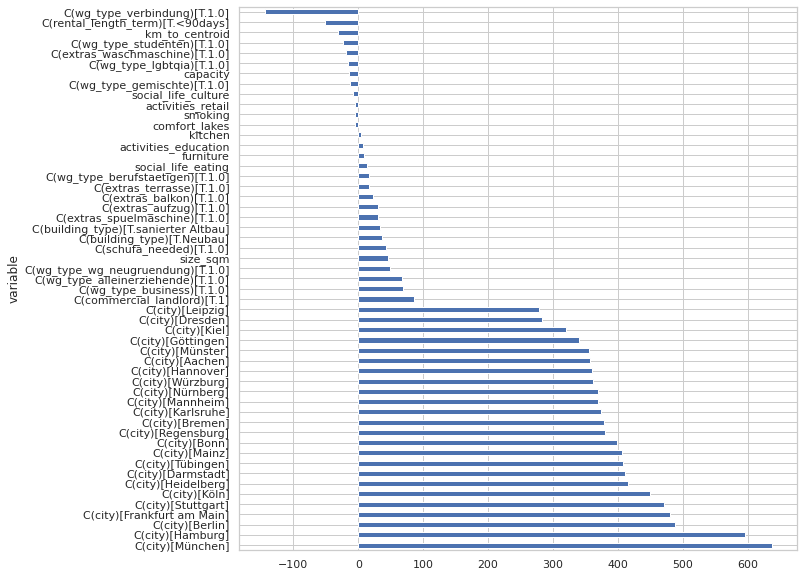

In [48]:
df = return_significative_coef(model_city).set_index('variable')
print(df)

sns.set_theme(style = "whitegrid", font_scale= 1)
fig = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
df.coef.plot(kind='barh');

# Linear model Apartment

In [49]:
flathouse_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8054 entries, 0 to 8053
Columns: 125 entries, id to cos_day_week_int
dtypes: Float64(2), Int64(1), datetime64[ns](3), float64(96), int64(6), object(17)
memory usage: 7.7+ MB


In [50]:
# define columns to work
features = [
    'km_to_centroid',
    'sin_degrees_to_centroid',
    'cos_degrees_to_centroid',
    
    'comfort_leisure_spots',
    'comfort_warehouse',
    'activities_education',
    'mobility_public_transport_bus',
    'activities_economic',
    'comfort_industrial',
    'activities_goverment',
    'social_life_eating',
    'comfort_comfort_spots',
    'social_life_culture',
    'activities_supermarket',
##     'activities_public_service',
    'social_life_community',
    'comfort_leisure_mass',
    'activities_educational',
    'mobility_street_secondary',
    'mobility_public_transport_rail',
    'activities_retail',
    'social_life_night_life',
    'comfort_green_natural',
    'comfort_railway',
    'mobility_bike_infraestructure',
##     'comfort_green_forests',
    'mobility_street_primary',
    'comfort_lakes',
##     'activities_health_regional',
    'activities_health_local',
    'comfort_green_space',
    'comfort_rivers',
    'activities_post',
    'comfort_green_parks',
    'comfort_street_motorway'
]

target = 'price_euros'

selected_num_features = [
    'size_sqm',
#             'days_available',
            'available_rooms',
#             'capacity',
#             'male_flatmates',
#             'female_flatmates',
#             'diverse_flatmates',
    
#             'cold_rent_euros',
#             'mandatory_costs_euros',
#             'extra_costs_euros',
            'transfer_costs_euros',
#             'deposit',

#             'building_floor',
            'furniture',
            'kitchen',
#             'public_transport_distance',
#             'home_total_size',
#             'smoking',
    
#             'min_age_flatmates',
#             'max_age_flatmates',
    
#             'min_age_searched',
#             'max_age_searched',
    
#             'number_languages',
    
#             'sin_published_at',
#             'cos_published_at',
#             'sin_day_week_int',
#             'cos_day_week_int'
    
] + features
selected_cat_features = ['city',
                         'commercial_landlord',
            'rental_length_term',
#             'energy',
            'wg_possible',
            'building_type',
#             'shower_type',
#             'floor_type',
#             'heating',
#             'internet',
#             'parking',
                         
            'schufa_needed',
                         
            'extras_waschmaschine',
            'extras_spuelmaschine',
            'extras_terrasse',
            'extras_balkon',
            'extras_garten',
#             'extras_gartenmitbenutzung',
            'extras_keller',
            'extras_aufzug',
            'extras_haustiere',
            'extras_fahrradkeller',
            'extras_dachboden',
                         
#             'languages_deutsch',
#             'languages_englisch',
                         
#             'wg_type_studenten',
#             'wg_type_keine_zweck',
#             'wg_type_maenner',
#             'wg_type_business',
#             'wg_type_wohnheim',
#             'wg_type_vegetarisch_vegan',
#             'wg_type_alleinerziehende',
#             'wg_type_funktionale',
#             'wg_type_berufstaetigen',
#             'wg_type_gemischte',
#             'wg_type_mit_kindern',
#             'wg_type_verbindung',
#             'wg_type_lgbtqia',
#             'wg_type_senioren',
#             'wg_type_inklusive',
#             'wg_type_wg_neugruendung',
                         
            'tv_kabel',
            'tv_satellit',
                         
#             'gender_searched',
                         
#             'age_category_searched'
                        ]
all_columns = [target] + selected_num_features + selected_cat_features

columns_to_zscore = selected_num_features


# Filter dataframe for modelling
df_zscored = flathouse_df[all_columns#+['city']
                     ].copy()

df_zscored.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8054 entries, 0 to 8053
Data columns (total 56 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   price_euros                     8054 non-null   float64
 1   size_sqm                        8054 non-null   float64
 2   available_rooms                 8054 non-null   float64
 3   transfer_costs_euros            2294 non-null   float64
 4   furniture                       2294 non-null   float64
 5   kitchen                         2294 non-null   float64
 6   km_to_centroid                  3875 non-null   float64
 7   sin_degrees_to_centroid         3875 non-null   float64
 8   cos_degrees_to_centroid         3875 non-null   float64
 9   comfort_leisure_spots           3875 non-null   float64
 10  comfort_warehouse               3875 non-null   float64
 11  activities_education            3875 non-null   float64
 12  mobility_public_transport_bus   38

In [51]:
df_zscored = df_zscored.dropna(axis=0)
# z-scoring columns
df_zscored = standardize_features(df_zscored, columns_to_zscore)

# Filter table if needed
df_city = df_zscored#[df_zscored['city'] == 'Leipzig']
df_city.shape

(953, 56)

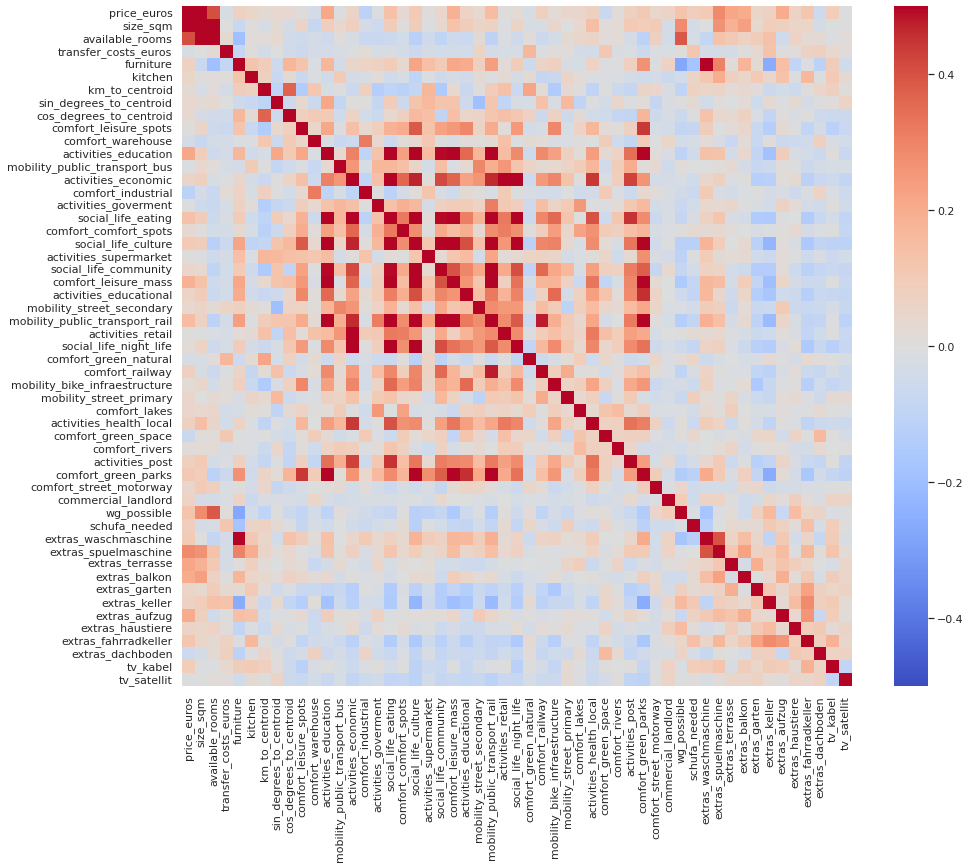

In [52]:
sns.set_theme(style = "whitegrid", font_scale= 1)
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(15, 12.5))

sns.heatmap(df_city.corr(), cmap='coolwarm', 
            annot = False, 
            annot_kws={"size": 8},
            vmin=-0.5, vmax=0.5);

In [53]:
data_corr = df_city.corr()

corr_df = data_corr.unstack().reset_index() # Unstack correlation matrix 
corr_df.columns = ['feature_1','feature_2', 'correlation'] # rename columns
corr_df.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] # Remove self correlation
corr_df.head(30)

,feature_1,feature_2,correlation
55,size_sqm,available_rooms,0.724467
107,available_rooms,size_sqm,0.724467
978,social_life_culture,mobility_public_transport_rail,0.712601
1290,mobility_public_transport_rail,social_life_culture,0.712601
607,activities_education,mobility_public_transport_rail,0.688878
1283,mobility_public_transport_rail,activities_education,0.688878
705,activities_economic,social_life_eating,0.688118
861,social_life_eating,activities_economic,0.688118
604,activities_education,comfort_leisure_mass,0.682905
1124,comfort_leisure_mass,activities_education,0.682905


In [54]:
# Variation Inflation Factor (VIF) analysis
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
df = pd.DataFrame()

df["features"] = columns_to_zscore

df["vif_index"] = [vif(df_city[columns_to_zscore].values, i) for i in range(df_city[columns_to_zscore].shape[1])]

round(df.sort_values(by="vif_index", ascending = False),2)

,features,vif_index
23,mobility_public_transport_rail,4.98
17,social_life_culture,4.37
35,comfort_green_parks,3.28
15,social_life_eating,3.15
10,activities_education,3.10
20,comfort_leisure_mass,2.95
12,activities_economic,2.89
1,available_rooms,2.43
0,size_sqm,2.42
19,social_life_community,2.06


In [55]:
# OLS model
formula = target + ' ~ ' + ' + '.join(selected_num_features) + ' + ' + ' + '.join(['C('+feat+')-1' for feat in selected_cat_features]) + '-1'

model_city = smf.ols(formula = formula, data=df_city).fit()
model_city.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            price_euros   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     11.53
Date:                Fri, 26 Aug 2022   Prob (F-statistic):           1.96e-96
Time:                        12:02:26   Log-Likelihood:                -6857.2
No. Observations:                 953   AIC:                         1.389e+04
Df Residuals:                     864   BIC:                         1.432e+04
Df Model:                          88                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
C(city)[Aachen]                        661.1073     86.334      7.658      0.000     491.659     830.556
C(city)[Berlin]                       1006.9813     57.336     17.563      0.000     894.448    1119.515
C(city)[Bonn]                          849.6894    116.431      7.298      0.000     621.169    1078.210
C(city)[Bremen]                        862.7821    126.039      6.845      0.000     615.404    1110.160
C(city)[Darmstadt]                    1024.9283    127.847      8.017      0.000     774.002    1275.855
C(city)[Dresden]                       637.2288     91.363      6.975      0.000     457.909     816.548
C(city)[Frankfurt am Main]            1054.4785     78.931     13.360      0.000     899.560    1209.397
C(city)[Göttingen]                     683.1849    117.113      5.834      0.000     453.326     913.043
C(city)[Hamburg]                      1384.2043    142.333      9.725      0.000    1104.846    1663.562
C(city)[Hannover]                      694.8944     95.696      7.261      0.000     507.070     882.719
C(city)[Heidelberg]                    911.1172    130.241      6.996      0.000     655.492    1166.742
C(city)[Karlsruhe]                     759.9923    147.639      5.148      0.000     470.220    1049.765
C(city)[Kiel]                          804.3268    183.783      4.377      0.000     443.613    1165.040
C(city)[Köln]                          982.3867     69.065     14.224      0.000     846.832    1117.941
C(city)[Leipzig]                       537.3278     80.474      6.677      0.000     379.381     695.274
C(city)[Mainz]                         854.0759    115.486      7.395      0.000     627.410    1080.742
C(city)[Mannheim]                      724.9680    100.123      7.241      0.000     528.455     921.481
C(city)[München]                      1270.4825     68.316     18.597      0.000    1136.397    1404.568
C(city)[Münster]                       636.1686    127.418      4.993      0.000     386.084     886.253
C(city)[Nürnberg]                      655.3768    108.847      6.021      0.000     441.741     869.012
C(city)[Regensburg]                    734.5672    140.270      5.237      0.000     459.258    1009.877
C(city)[Stuttgart]                     997.2966     75.715     13.172      0.000     848.689    1145.904
C(city)[Tübingen]                     1234.5620    224.772      5.493      0.000     793.399    1675.725
C(city)[Würzburg]                      748.6457    132.096      5.667      0.000     489.378    1007.913
C(commercial_landlord)[T.1]            245.9669    129.138      1.905      0.057      -7.495     499.429
C(rental_length_term)[T.<270days]        2.6556     53.243      0.050      0.960    -101.846     107.157
C(rental_length_term)[T.<365days]     

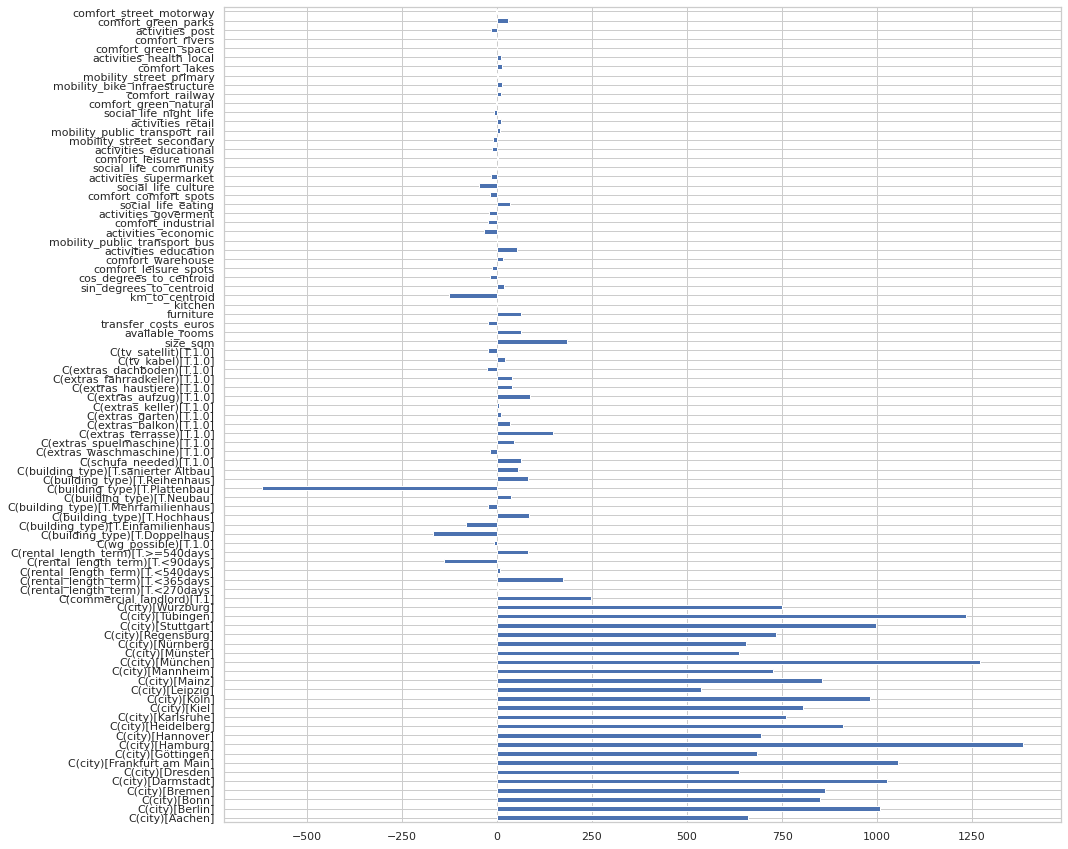

In [56]:
sns.set_theme(style = "whitegrid", font_scale= 1)
fig = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))

model_city.params[0:].plot(kind='barh');

RMSE: 322.60111847943585
RMSE base model: 475.6716908386467


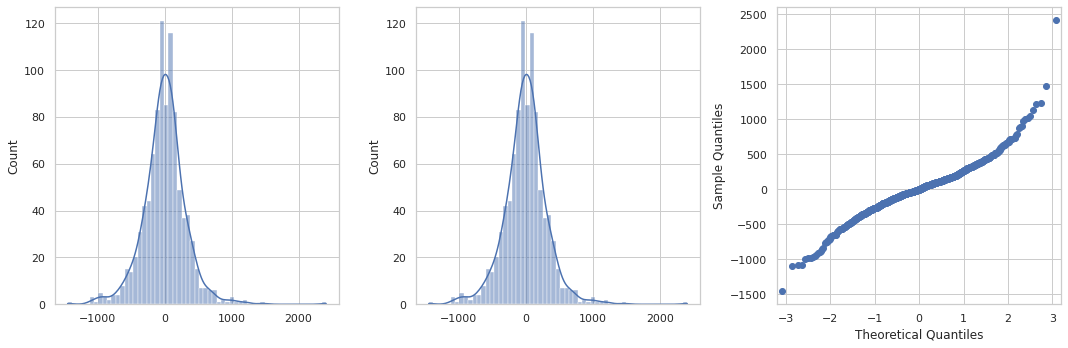

In [57]:
y_pred = model_city.predict(df_city)
y_base = [np.mean(df_city['price_euros'])]*len(y_pred)
y_true = df_city['price_euros']

print(f'RMSE: {np.sqrt(((y_pred - y_true) ** 2).mean())}')
print(f'RMSE base model: {np.sqrt(((y_base - y_true) ** 2).mean())}')

n=len(df_city)
residuals = y_pred - y_true
residuals_base = y_pred - y_true
# residuals.std()/orders.delay_vs_expected.std() * 1/(n**0.5)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
sns.histplot(-residuals, kde=True, edgecolor='w', ax=ax1)
sns.histplot(-residuals_base, kde=True, edgecolor='w', ax=ax2)

# https://stats.stackexchange.com/questions/101274/how-to-interpret-a-qq-plot
sm.qqplot(model_city.resid, ax=ax3)
plt.tight_layout()
fig.show();

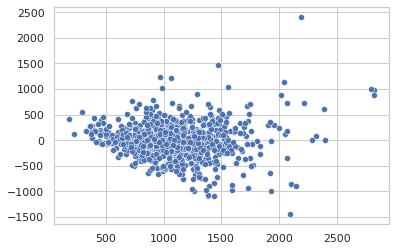

In [58]:
sns.scatterplot(x=model_city.predict(df_city), y=model_city.resid);

                                        p_value         coef
variable                                                    
C(city)[Hamburg]                   2.772006e-21  1384.204295
C(city)[München]                   3.453676e-65  1270.482519
C(city)[Tübingen]                  5.213146e-08  1234.562028
C(city)[Frankfurt am Main]         3.832720e-37  1054.478534
C(city)[Darmstadt]                 3.512028e-15  1024.928299
C(city)[Berlin]                    2.794312e-59  1006.981300
C(city)[Stuttgart]                 3.075586e-36   997.296580
C(city)[Köln]                      2.079742e-41   982.386740
C(city)[Heidelberg]                5.291905e-12   911.117184
C(city)[Bremen]                    1.445750e-11   862.782100
C(city)[Mainz]                     3.333207e-13   854.075883
C(city)[Bonn]                      6.629194e-13   849.689359
C(city)[Kiel]                      1.353478e-05   804.326842
C(city)[Karlsruhe]                 3.267053e-07   759.992263
C(city)[Würzburg]       

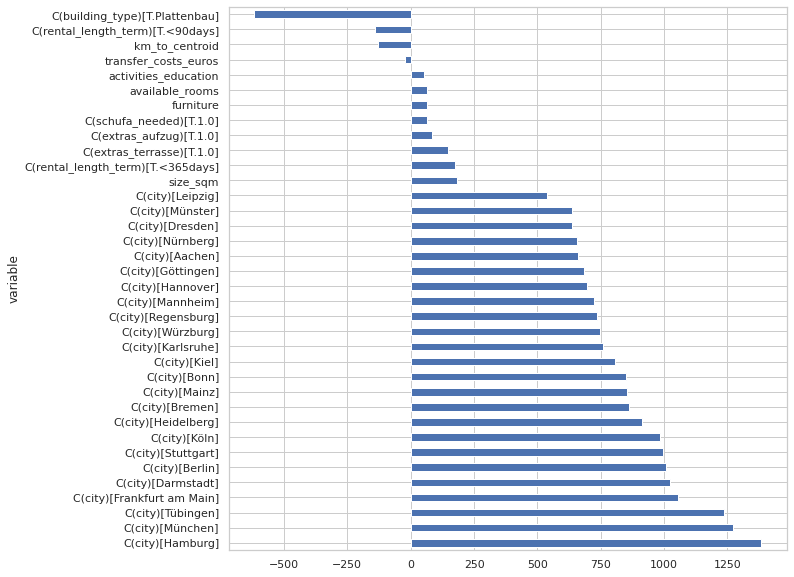

In [59]:
df = return_significative_coef(model_city).set_index('variable')
print(df)

sns.set_theme(style = "whitegrid", font_scale= 1)
fig = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
df.coef.plot(kind='barh');

# Linear model Single-room flats

In [60]:
singleroom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7477 entries, 0 to 7476
Columns: 125 entries, id to cos_day_week_int
dtypes: Float64(2), Int64(1), datetime64[ns](3), float64(96), int64(6), object(17)
memory usage: 7.2+ MB


In [61]:
# define columns to work
features = [
    'km_to_centroid',
    'sin_degrees_to_centroid',
    'cos_degrees_to_centroid',
    
    'comfort_leisure_spots',
    'comfort_warehouse',
    'activities_education',
    'mobility_public_transport_bus',
    'activities_economic',
    'comfort_industrial',
    'activities_goverment',
    'social_life_eating',
    'comfort_comfort_spots',
    'social_life_culture',
    'activities_supermarket',
##     'activities_public_service',
    'social_life_community',
    'comfort_leisure_mass',
    'activities_educational',
    'mobility_street_secondary',
    'mobility_public_transport_rail',
    'activities_retail',
    'social_life_night_life',
    'comfort_green_natural',
    'comfort_railway',
    'mobility_bike_infraestructure',
##     'comfort_green_forests',
    'mobility_street_primary',
    'comfort_lakes',
##     'activities_health_regional',
    'activities_health_local',
    'comfort_green_space',
    'comfort_rivers',
    'activities_post',
    'comfort_green_parks',
    'comfort_street_motorway'
]

target = 'price_euros'

selected_num_features = [
    'size_sqm',
#             'days_available',
#             'available_rooms',
#             'capacity',
#             'male_flatmates',
#             'female_flatmates',
#             'diverse_flatmates',
    
#             'cold_rent_euros',
#             'mandatory_costs_euros',
#             'extra_costs_euros',
            'transfer_costs_euros',
#             'deposit',

            'building_floor',
            'furniture',
            'kitchen',
#             'public_transport_distance',
#             'home_total_size',
            'smoking',
    
#             'min_age_flatmates',
#             'max_age_flatmates',
    
#             'min_age_searched',
#             'max_age_searched',
    
#             'number_languages',
    
#             'sin_published_at',
#             'cos_published_at',
#             'sin_day_week_int',
#             'cos_day_week_int'
    
] + features
selected_cat_features = ['city',
                         'commercial_landlord',
            'rental_length_term',
#             'energy',
#             'wg_possible',
            'building_type',
#             'shower_type',
#             'floor_type',
#             'heating',
#             'internet',
#             'parking',
                         
            'schufa_needed',
                         
            'extras_waschmaschine',
            'extras_spuelmaschine',
            'extras_terrasse',
            'extras_balkon',
            'extras_garten',
#             'extras_gartenmitbenutzung',
            'extras_keller',
            'extras_aufzug',
            'extras_haustiere',
            'extras_fahrradkeller',
            'extras_dachboden',
                         
#             'languages_deutsch',
#             'languages_englisch',
                         
#             'wg_type_studenten',
#             'wg_type_keine_zweck',
#             'wg_type_maenner',
#             'wg_type_business',
#             'wg_type_wohnheim',
#             'wg_type_vegetarisch_vegan',
#             'wg_type_alleinerziehende',
#             'wg_type_funktionale',
#             'wg_type_berufstaetigen',
#             'wg_type_gemischte',
#             'wg_type_mit_kindern',
#             'wg_type_verbindung',
#             'wg_type_lgbtqia',
#             'wg_type_senioren',
#             'wg_type_inklusive',
#             'wg_type_wg_neugruendung',
                         
            'tv_kabel',
            'tv_satellit',
                         
            'gender_searched',
                         
            'age_category_searched'
                        ]
all_columns = [target] + selected_num_features + selected_cat_features

columns_to_zscore = selected_num_features


# Filter dataframe for modelling
df_zscored = singleroom_df[all_columns#+['city']
                     ].copy()

df_zscored.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7477 entries, 0 to 7476
Data columns (total 58 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   price_euros                     7477 non-null   float64
 1   size_sqm                        7477 non-null   float64
 2   transfer_costs_euros            1886 non-null   float64
 3   building_floor                  1662 non-null   float64
 4   furniture                       1886 non-null   float64
 5   kitchen                         1886 non-null   float64
 6   smoking                         1886 non-null   float64
 7   km_to_centroid                  3626 non-null   float64
 8   sin_degrees_to_centroid         3626 non-null   float64
 9   cos_degrees_to_centroid         3626 non-null   float64
 10  comfort_leisure_spots           3626 non-null   float64
 11  comfort_warehouse               3626 non-null   float64
 12  activities_education            36

In [62]:
df_zscored = df_zscored.dropna(axis=0)
# z-scoring columns
df_zscored = standardize_features(df_zscored, columns_to_zscore)

# Filter table if needed
df_city = df_zscored#[df_zscored['city'] == 'Leipzig']
df_city.shape

(699, 58)

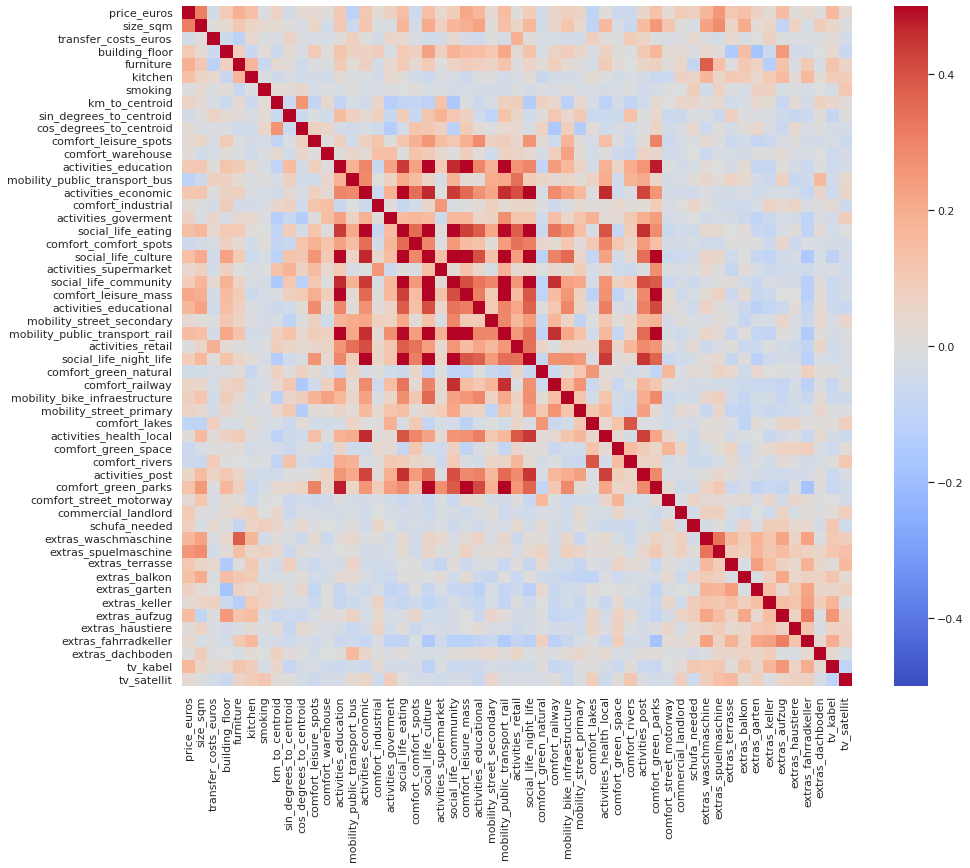

In [63]:
sns.set_theme(style = "whitegrid", font_scale= 1)
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(15, 12.5))

sns.heatmap(df_city.corr(), cmap='coolwarm', 
            annot = False, 
            annot_kws={"size": 8},
            vmin=-0.5, vmax=0.5);

In [64]:
data_corr = df_city.corr()

corr_df = data_corr.unstack().reset_index() # Unstack correlation matrix 
corr_df.columns = ['feature_1','feature_2', 'correlation'] # rename columns
corr_df.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] # Remove self correlation
corr_df.head(30)

,feature_1,feature_2,correlation
1032,social_life_culture,mobility_public_transport_rail,0.721438
1344,mobility_public_transport_rail,social_life_culture,0.721438
928,social_life_eating,social_life_night_life,0.718332
1448,social_life_night_life,social_life_eating,0.718332
1029,social_life_culture,comfort_leisure_mass,0.693248
1185,comfort_leisure_mass,social_life_culture,0.693248
1044,social_life_culture,comfort_green_parks,0.657645
1980,comfort_green_parks,social_life_culture,0.657645
1191,comfort_leisure_mass,mobility_public_transport_rail,0.635828
1347,mobility_public_transport_rail,comfort_leisure_mass,0.635828


In [65]:
# Variation Inflation Factor (VIF) analysis
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
df = pd.DataFrame()

df["features"] = columns_to_zscore

df["vif_index"] = [vif(df_city[columns_to_zscore].values, i) for i in range(df_city[columns_to_zscore].shape[1])]

round(df.sort_values(by="vif_index", ascending = False),2)

,features,vif_index
18,social_life_culture,4.42
24,mobility_public_transport_rail,4.39
16,social_life_eating,3.44
26,social_life_night_life,3.19
36,comfort_green_parks,2.83
21,comfort_leisure_mass,2.79
20,social_life_community,2.59
13,activities_economic,2.28
11,activities_education,2.23
32,activities_health_local,1.80


In [66]:
# OLS model
formula = target + ' ~ ' + ' + '.join(selected_num_features) + ' + ' + ' + '.join(['C('+feat+')-1' for feat in selected_cat_features]) + '-1'

model_city = smf.ols(formula = formula, data=df_city).fit()
model_city.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            price_euros   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.430
Method:                 Least Squares   F-statistic:                     6.982
Date:                Fri, 26 Aug 2022   Prob (F-statistic):           1.67e-50
Time:                        12:02:30   Log-Likelihood:                -4660.4
No. Observations:                 699   AIC:                             9499.
Df Residuals:                     610   BIC:                             9904.
Df Model:                          88                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
C(city)[Aachen]                        468.6000     62.692      7.475      0.000     345.481     591.719
C(city)[Berlin]                        650.7102     40.986     15.876      0.000     570.219     731.201
C(city)[Bonn]                          553.1908     79.479      6.960      0.000     397.106     709.276
C(city)[Bremen]                        429.7880     73.982      5.809      0.000     284.498     575.078
C(city)[Darmstadt]                     666.4773     96.681      6.894      0.000     476.609     856.345
C(city)[Dresden]                       372.6981     69.189      5.387      0.000     236.820     508.576
C(city)[Frankfurt am Main]             689.9345     56.750     12.157      0.000     578.486     801.383
C(city)[Göttingen]                     431.0278     83.219      5.179      0.000     267.598     594.457
C(city)[Hamburg]                       887.0856    114.442      7.751      0.000     662.337    1111.834
C(city)[Hannover]                      432.1589     81.350      5.312      0.000     272.399     591.919
C(city)[Heidelberg]                    620.6759     61.263     10.131      0.000     500.363     740.988
C(city)[Karlsruhe]                     485.9885     62.590      7.765      0.000     363.070     608.907
C(city)[Kiel]                          577.8442    127.218      4.542      0.000     328.006     827.683
C(city)[Köln]                          630.6606     45.627     13.822      0.000     541.056     720.265
C(city)[Leipzig]                       472.0070     60.107      7.853      0.000     353.966     590.048
C(city)[Mainz]                         560.5537     75.931      7.382      0.000     411.437     709.671
C(city)[Mannheim]                      456.5080     65.633      6.955      0.000     327.614     585.402
C(city)[München]                       909.4824     46.560     19.533      0.000     818.044    1000.921
C(city)[Münster]                       446.3926     84.982      5.253      0.000     279.499     613.286
C(city)[Nürnberg]                      535.6542     76.996      6.957      0.000     384.445     686.863
C(city)[Regensburg]                    471.8592     70.136      6.728      0.000     334.122     609.596
C(city)[Stuttgart]                     595.1629     57.083     10.426      0.000     483.060     707.266
C(city)[Tübingen]                      541.9381    115.749      4.682      0.000     314.623     769.253
C(city)[Würzburg]                      487.3428     72.047      6.764      0.000     345.852     628.833
C(commercial_landlord)[T.1]            -39.5669    104.367     -0.379      0.705    -244.530     165.396
C(rental_length_term)[T.<270days]       19.4672     42.378      0.459      0.646     -63.756     102.691
C(rental_length_term)[T.<365days]     

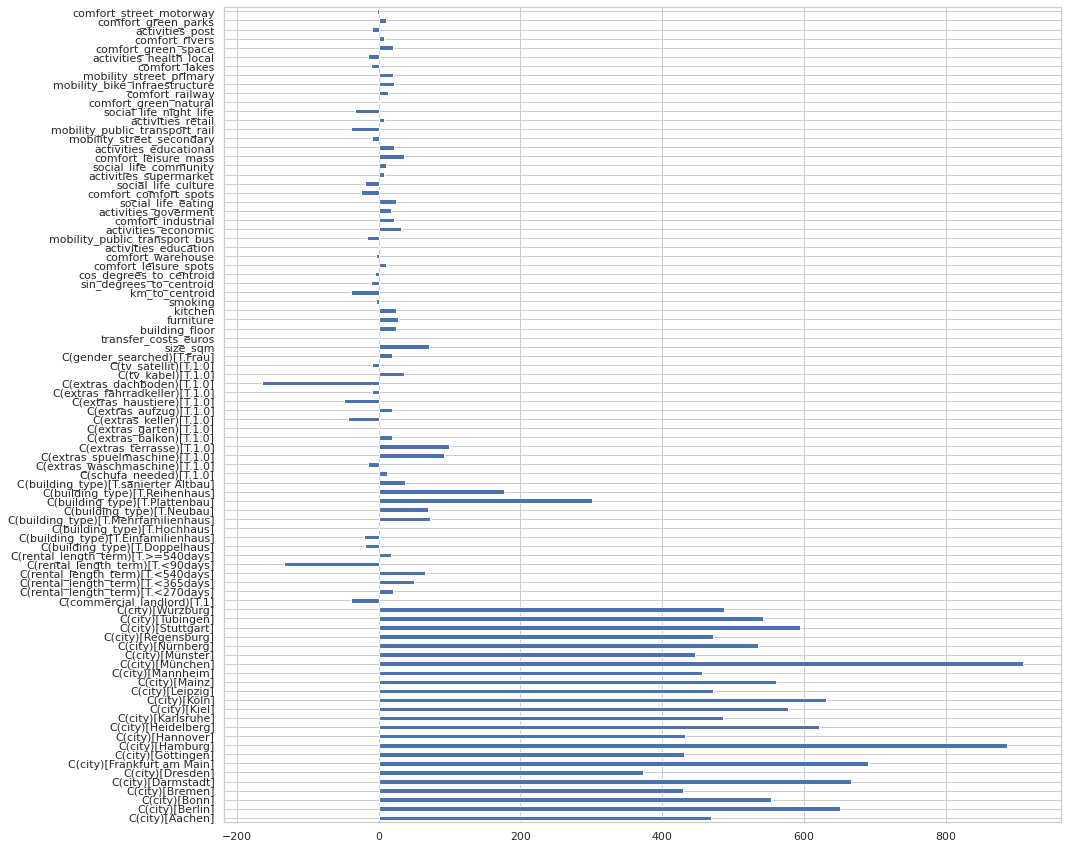

In [67]:
sns.set_theme(style = "whitegrid", font_scale= 1)
fig = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))

model_city.params[0:].plot(kind='barh');

RMSE: 190.24588650217663
RMSE base model: 269.5375011501552


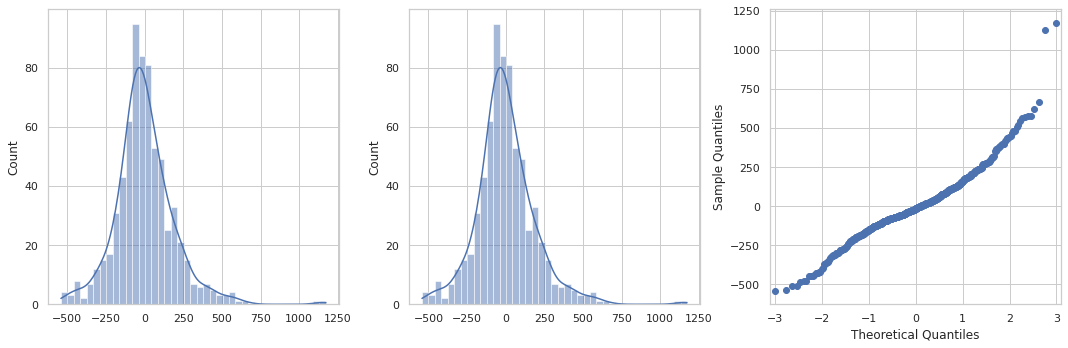

In [68]:
y_pred = model_city.predict(df_city)
y_base = [np.mean(df_city['price_euros'])]*len(y_pred)
y_true = df_city['price_euros']

print(f'RMSE: {np.sqrt(((y_pred - y_true) ** 2).mean())}')
print(f'RMSE base model: {np.sqrt(((y_base - y_true) ** 2).mean())}')

n=len(df_city)
residuals = y_pred - y_true
residuals_base = y_pred - y_true
# residuals.std()/orders.delay_vs_expected.std() * 1/(n**0.5)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
sns.histplot(-residuals, kde=True, edgecolor='w', ax=ax1)
sns.histplot(-residuals_base, kde=True, edgecolor='w', ax=ax2)

# https://stats.stackexchange.com/questions/101274/how-to-interpret-a-qq-plot
sm.qqplot(model_city.resid, ax=ax3)
plt.tight_layout()
fig.show();

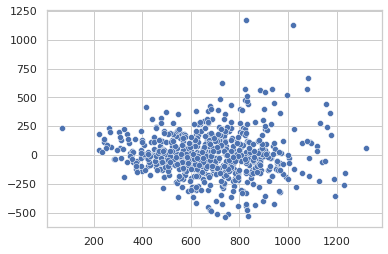

In [69]:
sns.scatterplot(x=model_city.predict(df_city), y=model_city.resid);

                                           p_value        coef
variable                                                      
C(city)[München]                      2.315856e-66  909.482351
C(city)[Hamburg]                      3.819863e-14  887.085578
C(city)[Frankfurt am Main]            1.324059e-30  689.934535
C(city)[Darmstadt]                    1.361589e-11  666.477337
C(city)[Berlin]                       9.143732e-48  650.710175
C(city)[Köln]                         5.336038e-38  630.660618
C(city)[Heidelberg]                   2.115170e-22  620.675918
C(city)[Stuttgart]                    1.557896e-23  595.162854
C(city)[Kiel]                         6.712889e-06  577.844199
C(city)[Mainz]                        5.117483e-13  560.553652
C(city)[Bonn]                         8.796883e-12  553.190848
C(city)[Tübingen]                     3.503616e-06  541.938146
C(city)[Nürnberg]                     8.991220e-12  535.654187
C(city)[Würzburg]                     3.145701e-11  487

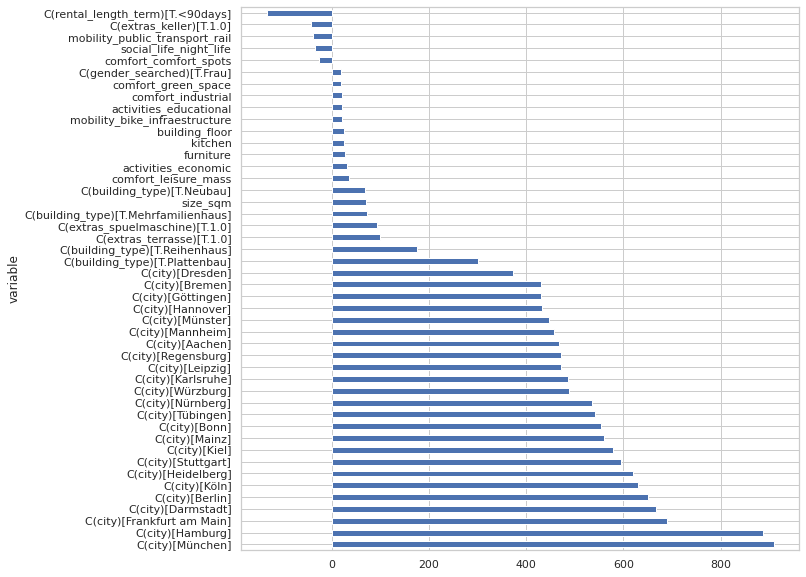

In [70]:
df = return_significative_coef(model_city).set_index('variable')
print(df)

sns.set_theme(style = "whitegrid", font_scale= 1)
fig = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
df.coef.plot(kind='barh');